In [29]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [32]:
def plot_pcs(data, axes):
    data = np.dot(eigvecs, data.T).T
    data = pd.DataFrame(data)
    ax = data.plot.scatter(ax=axes, x=0, y=1, title='Scatter plot for PC 1 and PC 2');
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2');

500
498


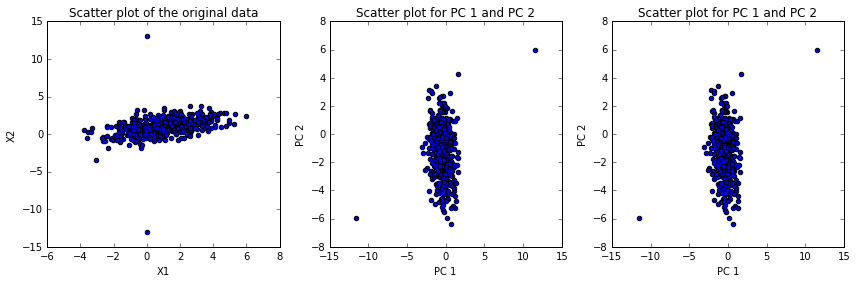

In [34]:
# Exercise 4.1
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

orig_data = pd.read_csv("pca2.csv")
orig_data.plot.scatter(ax=axes[0], x=0, y=1, title='Scatter plot of the original data')
eigvals, eigvecs = np.linalg.eigh(orig_data.cov())

# Transform into the coordinate system of the PCAs
plot_pcs(orig_data, axes[1])
# TODO What do you observe?

orig_data.drop([17, 157], inplace=True)
plot_pcs(orig_data, axes[2])
# TODO What is the difference?

figure.tight_layout()

